In [45]:
import pandas as pd
import pickle

path2 = "/Users/amaros/Desktop/mgss2/log_norm.pkl"

with open(path2, 'rb') as file:
        metabolomics = pickle.load(file)       

mgcsts_samples_df = pd.read_csv("../Data/mgCSTs.samples.df.csv")
color_mgCST = pd.read_csv("../Data/mgCST_sort_color.csv")

minclustersize = 10
deepsplit = 4

mgcsts_samples = mgcsts_samples_df[(mgcsts_samples_df['minClusterSize'] == minclustersize) & (mgcsts_samples_df['deepSplit'] == deepsplit)]
color_mgCST = color_mgCST[(color_mgCST['minClusterSize'] == minclustersize) & (color_mgCST['deepSplit'] == deepsplit)]

In [46]:
GroupA = (1,5)
GroupB = (6,8)

def data_pca(m1,m2):
    df1 = mgcsts_samples[mgcsts_samples['mgCST'].isin(range(m1[0],m1[1]+1))]
    df1.loc[:,'label'] = "GroupA"
    df2 = mgcsts_samples[mgcsts_samples['mgCST'].isin(range(m2[0],m2[1]+1))]
    df2.loc[:,'label'] = "GroupB"
    df3 = pd.concat([df1,df2], axis = 0)
    data1 = pd.merge(df3, metabolomics, on = "sampleID", how = "inner")
    return data1

data1 = data_pca(GroupA, GroupB)
mgCSTs = data1['mgCST']
groups = data1['label']
data1 = data1.drop(['dtc','domTaxa','relabund','minClusterSize','deepSplit', 'sampleID', 'mgCST', 'label'], axis = 1)
new_colors = color_mgCST[color_mgCST['mgCST'].isin(mgCSTs)]


/var/folders/h5/ld8fm2tx5hx6b_hqkmxxbx_00000gp/T/ipykernel_29833/2646575185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'label'] = "GroupA"
/var/folders/h5/ld8fm2tx5hx6b_hqkmxxbx_00000gp/T/ipykernel_29833/2646575185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'label'] = "GroupB"


In [47]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=6)
principal_components = pca.fit_transform(data1)
explained_variance = pca.explained_variance_ratio_
components_compo = pca.components_

<Axes: xlabel='PC1', ylabel='PC2'>

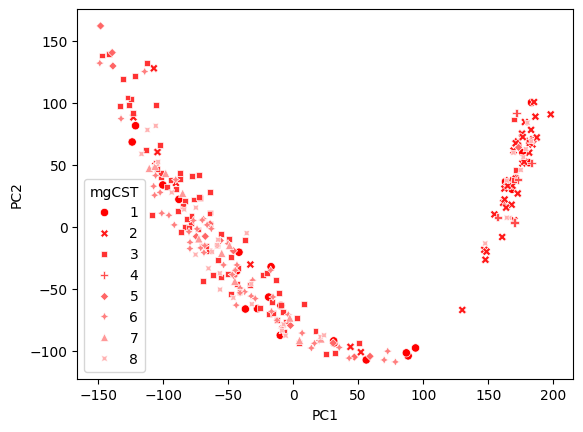

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

pca_df = pd.DataFrame(data = principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pca_df = pd.concat([pca_df, mgCSTs], axis=1)
pca_df = pca_df.sort_values(by='mgCST', ascending=True)
new_legend = new_colors['color_mgCST'].apply(lambda x : mcolors.to_rgba(x)).values
pca_df['mgCST'] = pca_df['mgCST'].astype(str)
sns.scatterplot(pca_df, x='PC1', y='PC2', hue='mgCST', style='mgCST', palette=list(new_legend))

In [54]:
import plotly.express as px

fig = px.scatter(pca_df, x='PC1', y='PC2', color='mgCST', symbol='mgCST',color_discrete_sequence=color_mgCST['color_mgCST'].values)
fig.show()

In [40]:
import numpy as np
cols = metabolomics.columns

def top_features(pc, n) :
        arr = pca.components_[pc]
        n_largest = n
        max_indices = np.argpartition(-arr, n_largest)[:n_largest]
        min_indices = np.argpartition(arr, n_largest)[:n_largest]
        pc_df_pos = pd.DataFrame({'Features':[cols[i] for i in max_indices],
                              'explained_variance' : [arr[i] for i in max_indices]}).sort_values(by='explained_variance', ascending=False)
        pc_df_neg = pd.DataFrame({'Features':[cols[i] for i in min_indices],
                              'explained_variance' : [arr[i] for i in min_indices]}).sort_values(by='explained_variance', ascending=True)
        return pc_df_pos.reset_index(drop=True), pc_df_neg.reset_index(drop=True)

In [46]:
top_features(0,5)[0]

,Features,explained_variance
0,N-acetylmethionine sulfoxide:phosphate,0.018238
1,thioproline:phosphate,0.017579
2,N-acetylarginine:phosphate,0.017164
3,sarcosine:phosphate,0.016922
4,hexadecasphingosine (d16:1)*:phosphate,0.016832


In [184]:
n = 5
PCs = ['PC1'] * n + ['PC2'] * n + ['PC3'] * n + ['PC4'] * n + ['PC5'] * n + ['PC6'] * n
plotly_df = pd.concat([top_features(0,n)[0],top_features(1,n)[0],top_features(2,n)[0],top_features(3,n)[0],top_features(4,n)[0],top_features(5,n)[0]], axis = 0)        
plotly_df['PCs'] = PCs
plotly_df = plotly_df.reset_index(drop=True)
plotly_df['feats_rank'] = [1,2,3,4,5]*6
plotly_df.head(10)

,Features,explained_variance,PCs,feats_rank
0,N-acetylmethionine sulfoxide:phosphate,0.018238,PC1,1
1,thioproline:phosphate,0.017579,PC1,2
2,N-acetylarginine:phosphate,0.017164,PC1,3
3,sarcosine:phosphate,0.016922,PC1,4
4,hexadecasphingosine (d16:1)*:phosphate,0.016832,PC1,5
5,spermidine:phosphate,0.014720,PC2,1
6,hydroxyproline:phosphate,0.014487,PC2,2
7,deoxycarnitine:phosphate,0.014400,PC2,3
8,3-(4-hydroxyphenyl)lactate (HPLA):phosphate,0.013363,PC2,4
9,dimethylarginine (ADMA + SDMA):phosphate,0.012428,PC2,5


In [189]:
import plotly.express as px

df2 = plotly_df.sort_values(['feats_rank', 'PCs']).reset_index(drop=True)
df2['feats_rank'] = df2['feats_rank'].astype(str) # if not as object type, barmode='group' does not work

fig = px.bar(df2, x='PCs', y='explained_variance', color='feats_rank', text='Features', barmode='group', title='5 most contributing features - Positive correlation')


fig.show()

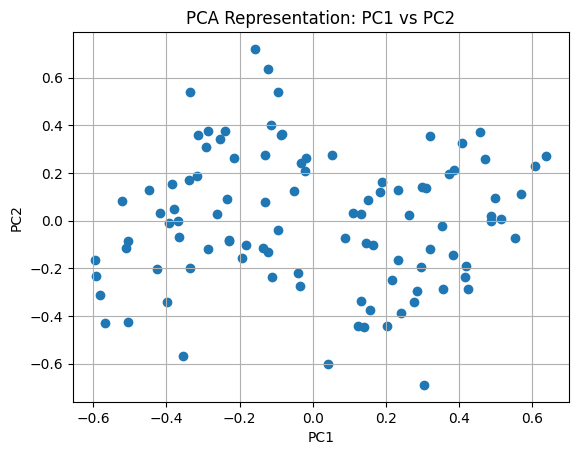

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data
data = np.random.rand(100, 3)  # Replace this with your actual data

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Create a scatter plot of PC1 vs PC2
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Representation: PC1 vs PC2')
plt.grid(True)
plt.show()


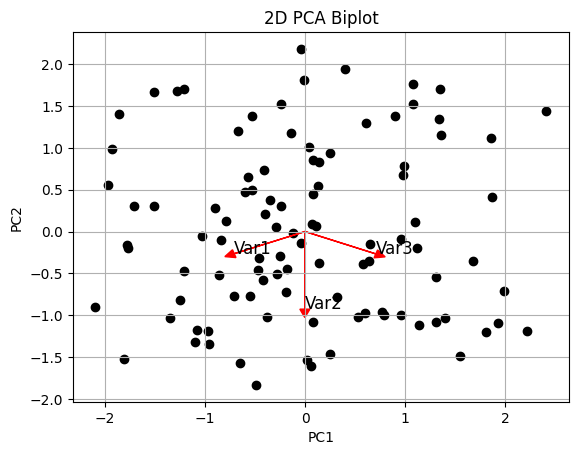

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example data (replace with your data)
data = np.random.rand(100, 3)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Create a scatter plot of PC1 vs PC2
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='black', marker='o')

# Add labels for the original variables as vectors (biplot)
for i, var_name in enumerate(['Var1', 'Var2', 'Var3']):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.text(pca.components_[0, i], pca.components_[1, i], var_name, fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Biplot')
plt.grid(True)
plt.show()
